In [1]:
%matplotlib inline

In [269]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import pickle
from vtk_rw import read_vtk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Load data

In [14]:
def load_pickle(pkl_file):
    pkl_in = open(pkl_file, 'r')
    pkl_dict = pickle.load(pkl_in)
    pkl_in.close()
    return pkl_dict

In [20]:
lh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl1000.vtk'
lh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
rh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl1000.vtk'
rh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
fullmask_file = '/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
lh_sulc = np.load(lh_sulc_file)
lv, lf, _ = read_vtk(lh_mesh_file)
rh_sulc = np.load(rh_sulc_file)
rv, rf, _ = read_vtk(rh_mesh_file)
fullmask = np.load(fullmask_file)

In [21]:
embed_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'
embed_dict = load_pickle(dict_file)
# normalize vectors
embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, fullmask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

In [47]:
t1_predict_file_0 = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0.pkl'
t1_predict_0 = load_pickle(t1_predict_file_0)
scatter_mask = np.where(t1_predict_0['t1']>1500)

In [209]:
T1=t1_predict_0['t1'][scatter_mask]
FC1=-embed[:,0][scatter_mask]

### Fitting

In [255]:
def linear(x, b0, b1):
    return b0+b1*x

In [223]:
def sigmoid(x, height, theta, xshift, yshift):
    return height / (1. + np.exp(-theta*(x-xshift))) + yshift

In [224]:
def polynomial_3(xs, b0, b1, b2, b3):
    return b0 + b1*xs + b2*xs**2 + b3*xs**3

In [225]:
xdata = FC1
ydata = (T1-np.mean(T1))/np.std(T1)
x = np.linspace(-2,2,100) #xdata.min(), xdata.max(), 100)

In [256]:
fitted_parms_lin, _ = curve_fit(linear, xdata, ydata)
predicted_ys_lin = linear(x, *fitted_parms_lin)

In [226]:
fitted_parms_sigmoid, _ = curve_fit(sigmoid, xdata, ydata)
predicted_ys_sigmoid = sigmoid(x, *fitted_parms_sigmoid)

In [227]:
fitted_parms_poly3, _ = curve_fit(polynomial_3, xdata, ydata)
predicted_ys_poly3 = polynomial_3(x, *fitted_parms_poly3)

In [257]:
predicted_T1_line_lin = predicted_ys_lin*np.std(T1)+np.mean(T1)
predicted_T1_lin = linear(FC1, *fitted_parms_lin)*np.std(T1)+np.mean(T1)

In [228]:
predicted_T1_line_sig = predicted_ys_sigmoid*np.std(T1)+np.mean(T1)
predicted_T1_sig = sigmoid(FC1, *fitted_parms_sigmoid)*np.std(T1)+np.mean(T1)

In [229]:
predicted_T1_line_poly3 = predicted_ys_poly3*np.std(T1)+np.mean(T1)
predicted_T1_poly3 = polynomial_3(FC1, *fitted_parms_poly3)*np.std(T1)+np.mean(T1)

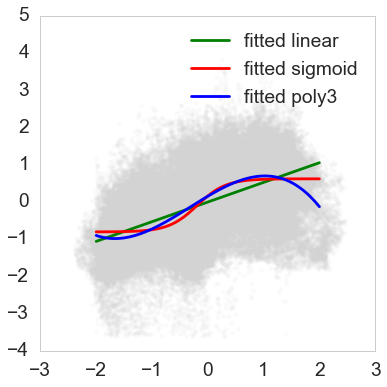

In [258]:
fig=plt.figure(figsize=(6,6))
plt.scatter(xdata, ydata, color='lightgrey', linewidth=0, alpha=0.1)
plt.plot(x, predicted_ys_lin, color='green', label='fitted linear')
plt.plot(x, predicted_ys_sigmoid, color='red', label='fitted sigmoid')
plt.plot(x, predicted_ys_poly3, color='blue', label='fitted poly3')
#plt.ylim([1600,2350])
#plt.xlim([-2.5, 2.5])
plt.legend()


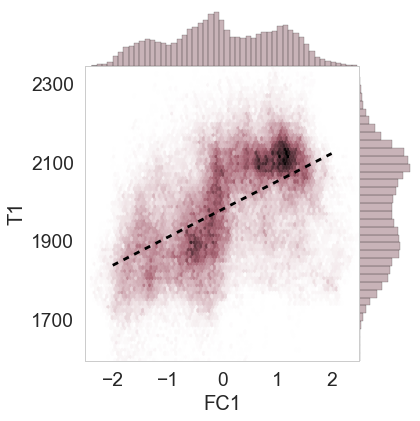

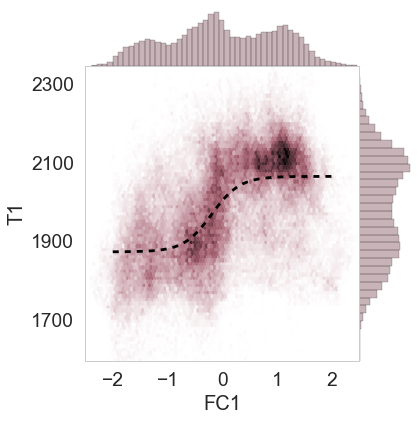

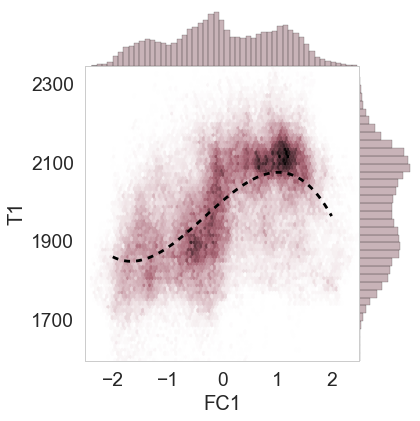

In [260]:
import seaborn as sns
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.2)
scatter_mask = np.where(t1_predict_0['t1']>1500)

xlim = (-2.5, 2.5)
ylim = (1600, 2350)
yticks = [1700, 1900,2100, 2300]
scatter_color = sns.xkcd_rgb['brownish purple']

fig = sns.jointplot(FC1, 
                    T1,
                    stat_func=None,space=0,ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.ax_joint.plot(x, predicted_T1_line_lin, 'k--')  
fig.set_axis_labels('FC1', 'T1', fontsize=20)
fig.ax_joint.set_yticks(yticks);

fig = sns.jointplot(FC1, 
                    T1,
                    stat_func=None,space=0,ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.ax_joint.plot(x, predicted_T1_line_sig, 'k--')  
fig.set_axis_labels('FC1', 'T1', fontsize=20)
fig.ax_joint.set_yticks(yticks);

fig = sns.jointplot(FC1, 
                    T1,
                    stat_func=None,space=0,ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.ax_joint.plot(x, predicted_T1_line_poly3, 'k--')  
fig.set_axis_labels('FC1', 'T1', fontsize=20)
fig.ax_joint.set_yticks(yticks);

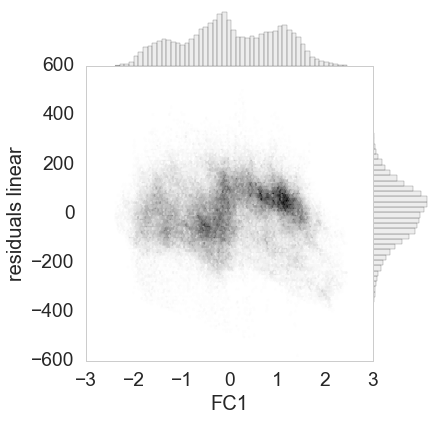

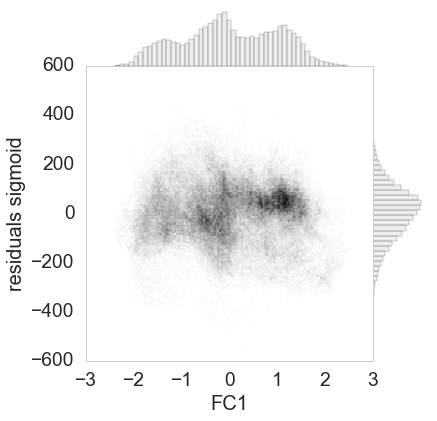

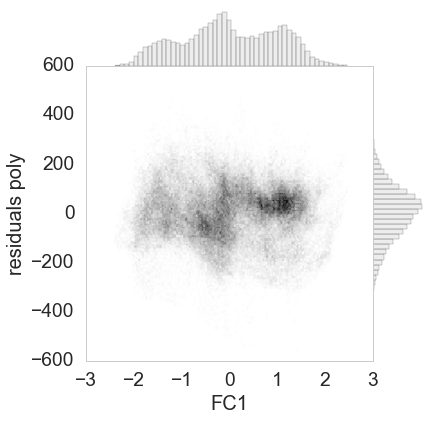

In [261]:
fig = sns.jointplot(FC1, T1-predicted_T1_lin,
                    stat_func=None,space=0,
                    kind="hex", size=6, color='lightgrey')
fig.set_axis_labels('FC1', 'residuals linear', fontsize=20)

fig = sns.jointplot(FC1, T1-predicted_T1_sig,
                    stat_func=None,space=0,
                    kind="hex", size=6, color='lightgrey')
fig.set_axis_labels('FC1', 'residuals sigmoid', fontsize=20)

fig = sns.jointplot(FC1, T1-predicted_T1_poly3,
                    stat_func=None,space=0,
                    kind="hex", size=6, color='lightgrey')
fig.set_axis_labels('FC1', 'residuals poly', fontsize=20)



In [182]:
import scipy.stats as stats

In [280]:
print 'linear', stats.pearsonr(T1, predicted_T1_lin)[0], stats.pearsonr(T1, predicted_T1_lin)[0]**2
print 'sigmoid', stats.pearsonr(T1, predicted_T1_sig)[0], stats.pearsonr(T1, predicted_T1_sig)[0]**2
print 'polynomial', stats.pearsonr(T1, predicted_T1_poly3)[0], stats.pearsonr(T1, predicted_T1_poly3)[0]**2

linear 0.528208342431 0.279004053013
sigmoid 0.570254760639 0.325190492032
polynomial 0.584902843591 0.342111336441


### Estimate covariance with sandwich estimator 

http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html

http://statsmodels.sourceforge.net/devel/generated/statsmodels.stats.sandwich_covariance.cov_hac.html#statsmodels.stats.sandwich_covariance.cov_hac

In [291]:
import statsmodels.api as sm

In [290]:
X = np.column_stack((np.ones(FC1.shape), FC1, FC1**2, FC1**3))

In [292]:
model = sm.OLS(T1, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 2.090e+04
Date:                Mon, 11 Jul 2016   Prob (F-statistic):               0.00
Time:                        14:32:19   Log-Likelihood:            -7.3668e+05
No. Observations:              120559   AIC:                         1.473e+06
Df Residuals:                  120555   BIC:                         1.473e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2005.3895      0.433   4627.799      0.0

In [308]:
print 'HC0 robust standard errors ', results.HC0_se

robust standard errors  [ 0.44867552  0.64045175  0.29782973  0.26647802]


In [312]:
print 'HC0 robust confidence intervals'
print [results.params[0]-1.96*results.HC0_se[0], results.params[0]+1.96*results.HC0_se[0]]
print [results.params[1]-1.96*results.HC0_se[1], results.params[1]+1.96*results.HC0_se[1]]
print [results.params[2]-1.96*results.HC0_se[2], results.params[2]+1.96*results.HC0_se[2]]
print [results.params[3]-1.96*results.HC0_se[3], results.params[3]+1.96*results.HC0_se[3]]

HC0 robust confidence intervals
[2004.5100590389718, 2006.2688670721693]
[117.76085948310764, 120.27143032636231]
[-23.020148314030532, -21.852655762707617]
[-23.794438223528001, -22.74984440159918]


In [317]:
print 'classic covariance matrix'
results.cov_params()

array([[ 0.18777962,  0.00145948, -0.08943381, -0.0033965 ],
       [ 0.00145948,  0.43603164, -0.0128934 , -0.16017996],
       [-0.08943381, -0.0128934 ,  0.0900097 ,  0.00825948],
       [-0.0033965 , -0.16017996,  0.00825948,  0.07611714]])

In [314]:
print 'HC0 robust covariance matrix'
results.cov_HC0

HC0 robust covariance matrix


array([[ 0.20130972, -0.01095711, -0.09518545, -0.00063213],
       [-0.01095711,  0.41017844, -0.0151753 , -0.15057   ],
       [-0.09518545, -0.0151753 ,  0.08870255,  0.01023153],
       [-0.00063213, -0.15057   ,  0.01023153,  0.07101053]])

In [320]:
import statsmodels.stats as sms
print 'HAC robust covariance matrix'
sms.sandwich_covariance.cov_hac(results)

HAC robust covariance matrix


array([[ 1.98474828, -0.35605331, -0.79387881,  0.13987919],
       [-0.35605331,  3.28348451,  0.08308834, -1.0757576 ],
       [-0.79387881,  0.08308834,  0.67156355, -0.04605766],
       [ 0.13987919, -1.0757576 , -0.04605766,  0.46968998]])

In [324]:
import scipy.stats as sps
print 'classic p', sps.norm.sf(abs(results.params[0]/results.bse[0]))*2
print 'robust  p', sps.norm.sf(abs(results.params[0]/results.HC0_se[0]))*2

classic p 0.0
robust  p 0.0
